# Preeliminary: Import and loading data

In [70]:
import os
HOME = os.getcwd()
from pathlib import Path
print(HOME)

HOME_PARENT = Path(HOME).parent
import sys
sys.path.append(str(HOME_PARENT))
sys.path.append(os.path.join(HOME_PARENT, 'scripts'))
print(sys.path)

c:\Users\bouab\DEV\UK_accidents\notebooks
['c:\\Users\\bouab\\DEV\\UK_accidents\\notebooks', 'C:\\Users\\bouab\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'C:\\Users\\bouab\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'C:\\Users\\bouab\\AppData\\Local\\Programs\\Python\\Python39\\lib', 'C:\\Users\\bouab\\AppData\\Local\\Programs\\Python\\Python39', 'c:\\Users\\bouab\\DEV\\UK_accidents\\env', '', 'c:\\Users\\bouab\\DEV\\UK_accidents\\env\\lib\\site-packages', 'c:\\Users\\bouab\\DEV\\UK_accidents\\env\\lib\\site-packages\\win32', 'c:\\Users\\bouab\\DEV\\UK_accidents\\env\\lib\\site-packages\\win32\\lib', 'c:\\Users\\bouab\\DEV\\UK_accidents\\env\\lib\\site-packages\\Pythonwin', 'c:\\Users\\bouab\\DEV\\UK_accidents', 'c:\\Users\\bouab\\DEV\\UK_accidents\\scripts', 'c:\\Users\\bouab\\DEV\\UK_accidents', 'c:\\Users\\bouab\\DEV\\UK_accidents\\scripts', 'c:\\Users\\bouab\\DEV\\UK_accidents', 'c:\\Users\\bouab\\DEV\\UK_accidents\\scripts']


In [71]:
import pandas as pd
CA_PATH = os.path.join(HOME_PARENT, 'data', 'casualities.csv')
ACC_PATH = os.path.join(HOME_PARENT, 'data', 'accidents.csv')
VE_PATH = os.path.join(HOME_PARENT, 'data', 'vehicles.csv')

In [72]:
# let's load the data as needed
CA = pd.read_csv(CA_PATH)
ACC = pd.read_csv(ACC_PATH)
VE = pd.read_csv(VE_PATH)

C:\Users\bouab\AppData\Local\Temp\ipykernel_4836\348515298.py:3: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  ACC = pd.read_csv(ACC_PATH)


In [73]:
# let's try to analyse only the accidents taking place in London
LONDON_DISTRICTS = [
"Westminster",
"Kensington and Chelsea", 
"Hammersmith and Fulham",
"Wandsworth", 
"Lambeth", 
"Southwark",
"Tower Hamlets", 
"Hackney", 
"Islington",
"Camden",
"Brent",
"Ealing",
"Hounslow",
"Richmond upon Thames",
"Kingston upon Thames",
"Merton",
"Sutton",
"Croydon",
"Bromley",
"Lewisham",
"Greenwich",
"Bexley",
"Barking and Dagenham",
"Redbridge",
"Newham",
"Waltham Forest",
"Haringey",
"Enfield",
"Barnet",
"Harrow",
"Hillingdon",
]

LONDON_DISTRICTS = {1, 12, 10, 9,8, 5,4, 3, 2, 29, 27, 25, 23, 24, 22, 
                    21, 20, 19, 18, 7, 6, 16, 14, 17, 31, 32, 30, 29, 26}


Considering the number data suggested by the 3 tables, we can see that the best way to combine the data available is to predict the casuality severity.

# The data: a dive into the data's documentation 
## Accidents

Going through the explanations of the fields, it is possible to reduce the number of features as some of them do not introduce any additional value for our predictive task.  
The following will be dropped:  
1. Location Easting OSGR (Null if not known)
2. Location Northing OSGR (Null if not known)    
These values represent the location of the accident with respect to a local geospatial system
3. The police attendance
4. Longitude and Latitude might be dropped as the data is already clustered into different districts
5. Accident Severity: this value is practically equivalent to the target: the severity of casualities
6. Police: The police's intervention takes place generally after the accident. Such intervention could not possible affect the accident's severity and the casualities' seriousness 

Additional remarks:
* The most seemingly important features are:
    1. 1st /2nd  Road Class / if it reflects quality
    2. weather conditions / Light Conditions
    3. Pedestrian Crossing Human control: we don't expect many accidents in conjuctions controlled by police officer: HOWEVER IT MIGHT HAVE SOME OVERLAPPING WITH CONJUNCTION CONTROL
    4. Urban / Rural area: Rural area are more likely to have more fatal accidents: more serious casualities
    5. SPEED LIMIT
These observations are to confirmed to denied through the EDA.
* geospatial information should be processed further or dropped
* The temporal data might be reduced to either the month or the year values if needed

## The vehicles


* The data provides a detailed description of the vehicle
* The fields most likely should be combined into a fewer but more general representations
* Certain fields might be dropped:
    1. Vehicle Location: can be deduced to a certain extent by the type of the road / location the accident took place
    2. Vehicle Maneouver is to be dropped
    3. There are two Hit Object features that can be merged into one
    4. The IMD level as well as the home area of the driver do not seem to have direct relation with the seriousness of the casuality
    5. any information about the driver can be found in the casuality table, so it should be dropped from the vehicle table 


# The data: a dive into the code

## The accidents table

In [74]:
# first let's start with removing the unncessary data
ACC.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [75]:
acc_drop_cols = ['Location_Easting_OSGR', 'Location_Northing_OSGR','Police_Force', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Number_of_Casualties']
ACC.drop(columns=acc_drop_cols, inplace=True)

In [76]:
ACC.columns

Index(['Accident_Index', 'Longitude', 'Latitude', 'Accident_Severity',
       'Number_of_Vehicles', 'Date', 'Day_of_Week', 'Time',
       'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area'],
      dtype='object')

In [77]:
# let's provide better names (and mainly shorter) for the featrures
new_acc_cols = {'Longitude': 'lng', 'Latitude': 'lat', 'Accident_Severity': 'y', 'Number_of_Vehicles': 'n_vehs', 'Local_Authority_(District)': 'district',
                'Local_Authority_(Highway)': 'highway', '1st_Road_Class': 'road_c1', '1st_Road_Number': 'road_n1', 'Road_Type':'road_type'
                , 'Light_Conditions': 'light', 'Weather_Conditions': 'weather', 'Road_Surface_Conditions': 'road_surface', 'Urban_or_Rural_Area': 'area_type'
                , "Junction_Detail": "junc_detail", "Junction_Control": "junc_control", "2nd_Road_Class": "road_c2", "2nd_Road_Number": "road_n2", 
                "Pedestrian_Crossing-Human_Control": "cross_control", "Pedestrian_Crossing-Physical_Facilities": "cross_facilities", 
                "Special_Conditions_at_Site": "special_conds", "Carriageway_Hazards": "hazards"}

from df_operations import new_col_names, to_columns
ACC = new_col_names(new_acc_cols, ACC)
# make sure to convert them to lowercase
ACC = to_columns(ACC, lambda c: c.lower().strip()) 

### ACC: Explatory Data Analysis

In [78]:
# first let's split the data
from df_operations import get_col_types, draw_unique_data_table, draw_missing_data_table
num_cols, cat_cols = get_col_types(ACC)

In [79]:
draw_unique_data_table(ACC)
# let's start with a small number of 

,n_unique
accident_index,1640597
lng,1148131
lat,1081779
road_n2,7382
road_n1,6988
date,3652
time,1439
district,416
highway,207
n_vehs,27


In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.clf()
acc_cat = ACC.loc[:, cat_cols]

small_cats = [c for c in  cat_cols if len(acc_cat[c].value_counts()) <= 10]
print(len(small_cats))


16


<Figure size 640x480 with 0 Axes>

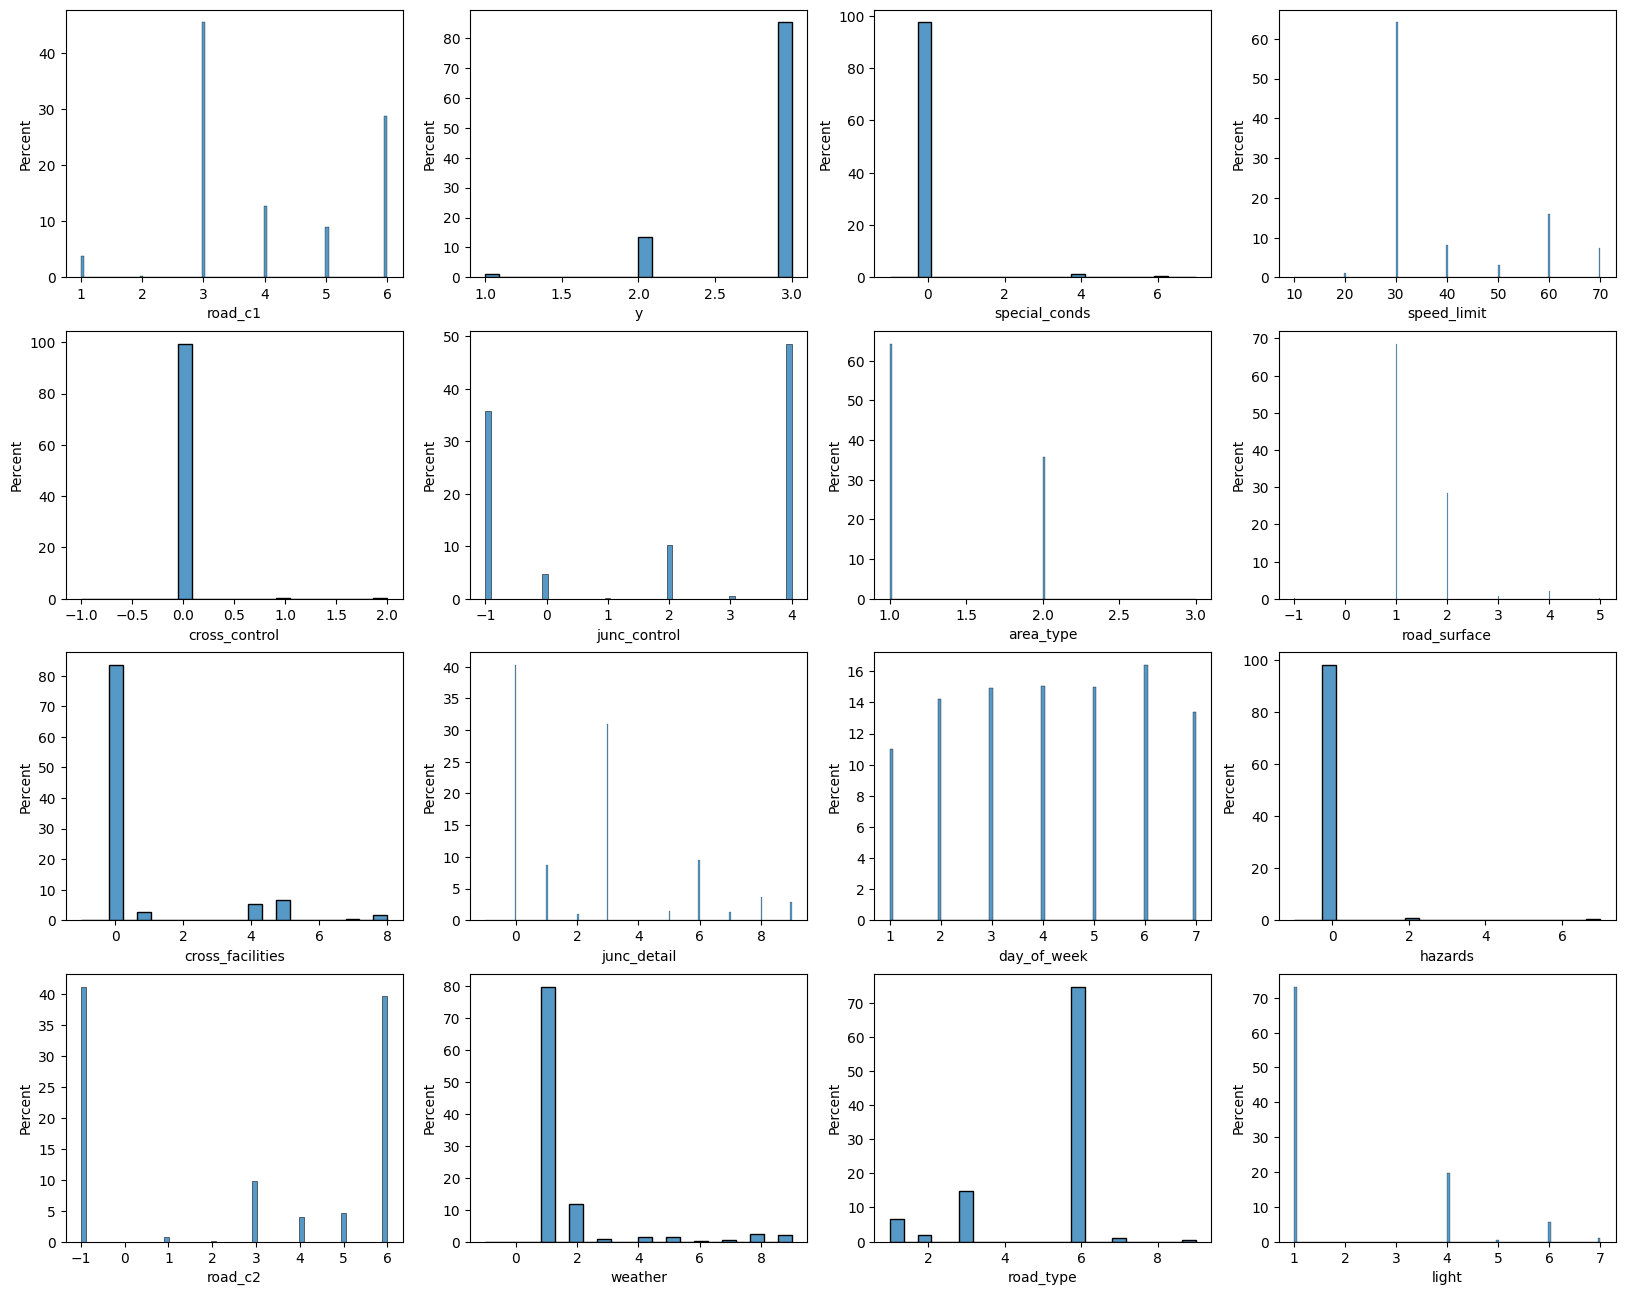

In [81]:
figure, axes = plt.subplots(4, 4,figsize=(20, 16), sharex=False, sharey=False)
for i, f in enumerate(small_cats):  
    chart = sns.histplot(ax=axes[i // 4, i % 4], data=acc_cat, x=f, stat='percent')
    # chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [82]:
# the following procedure will be used:
# if a certain value of a categorical variable does not correlate with fatal accidents: (a mere 2% of the total accidents), then this feature will either be dropped, or 
# the values will be rearranged
import numpy as np

def cat_feat_distribution(df: pd.DataFrame, feature: str, n_unique_as_discrete=20):
    assert feature in df.columns
    # make sure the indeed categorical
    assert feature not in set(list(df.select_dtypes(np.number).columns)) or len(df[feature].value_counts()) <= n_unique_as_discrete 

    return (df[feature].value_counts() / len(df))

for c in small_cats:
    print(cat_feat_distribution(acc_cat, c))

road_c1
3    0.453818
6    0.287965
4    0.127558
5    0.089316
1    0.038697
2    0.002646
Name: count, dtype: float64
y
3    0.851625
2    0.135342
1    0.013033
Name: count, dtype: float64
special_conds
 0    0.975258
 4    0.011669
 6    0.003558
 7    0.003195
 5    0.002434
 1    0.001860
 3    0.001497
 2    0.000518
-1    0.000011
Name: count, dtype: float64
speed_limit
30    0.641219
60    0.160479
40    0.081975
70    0.073269
50    0.032232
20    0.010805
10    0.000010
15    0.000010
Name: count, dtype: float64
cross_control
 0    0.994042
 2    0.003505
 1    0.002439
-1    0.000013
Name: count, dtype: float64
junc_control
 4    0.485861
-1    0.356774
 2    0.102629
 0    0.046883
 3    0.006179
 1    0.001674
Name: count, dtype: float64
area_type
1    0.642657
2    0.357256
3    0.000087
Name: count, dtype: float64
road_surface
 1    0.685742
 2    0.283764
 4    0.021049
 3    0.006669
 5    0.001463
-1    0.001314
Name: count, dtype: float64
cross_facilities
 0    0.83

In [83]:
len(acc_cat)

1640597

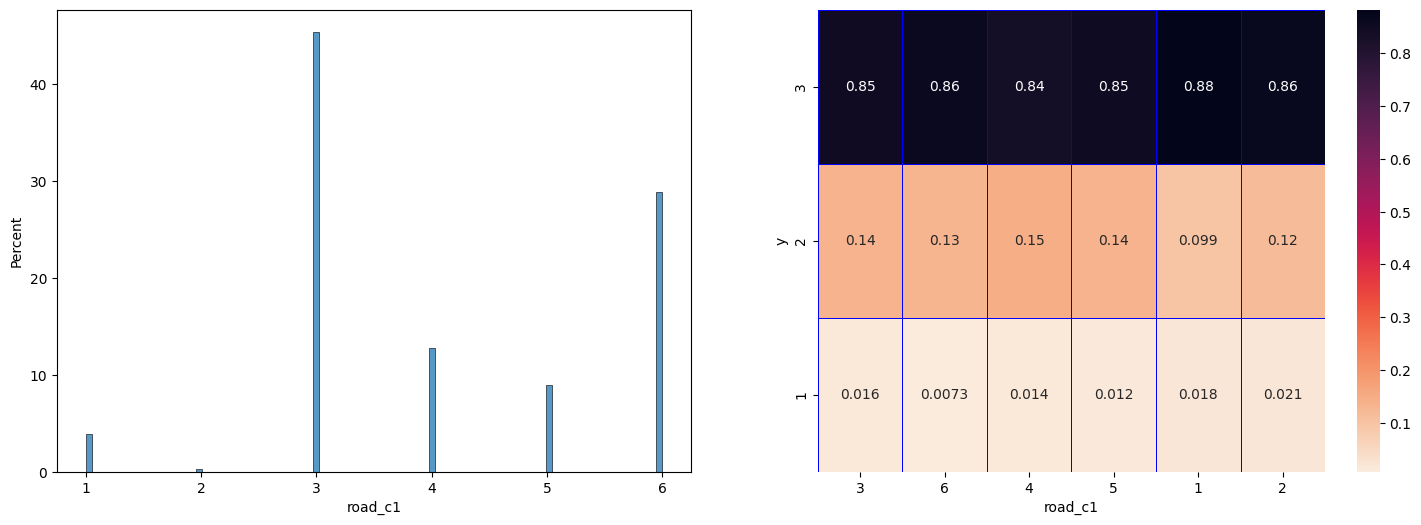

Please make sure to input two different categorical columns


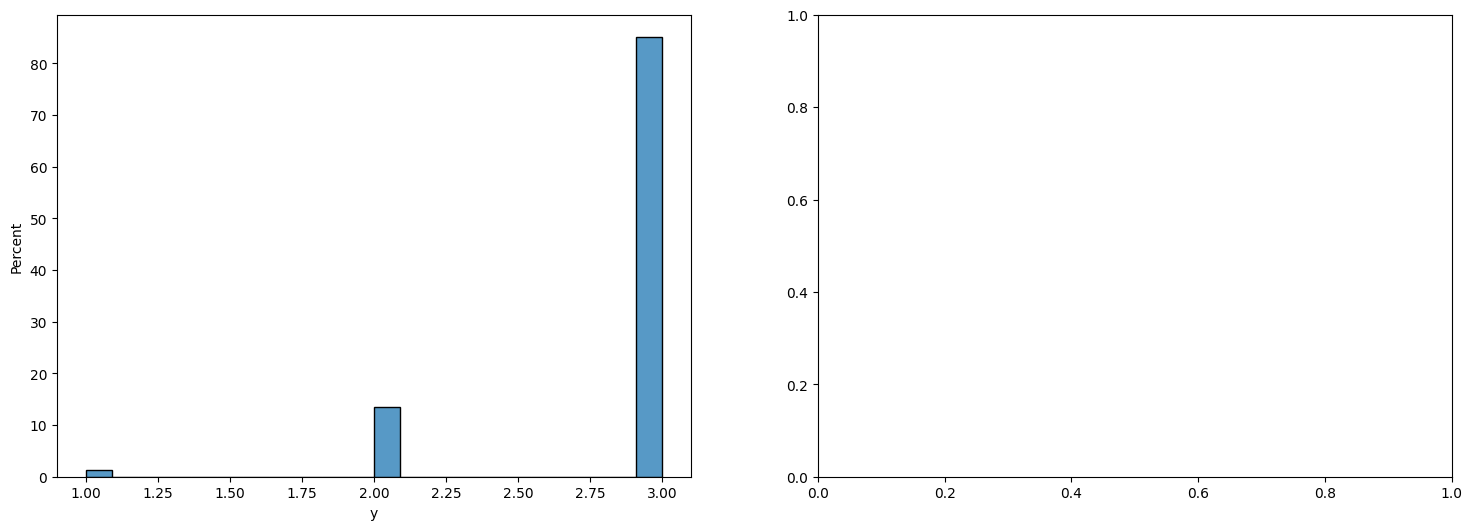

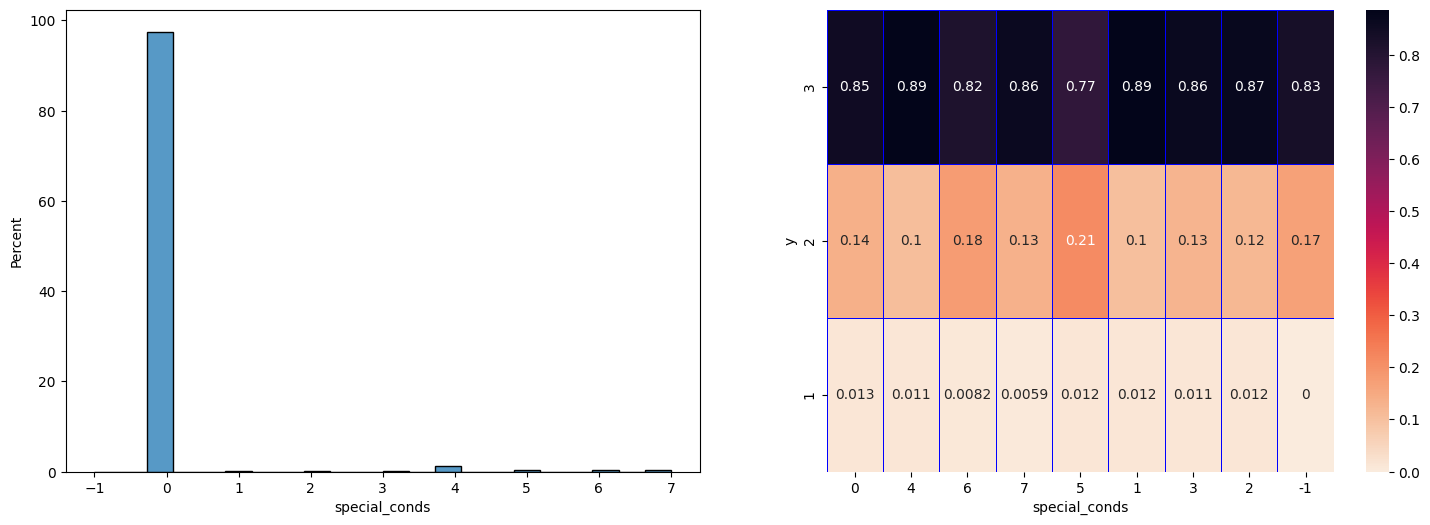

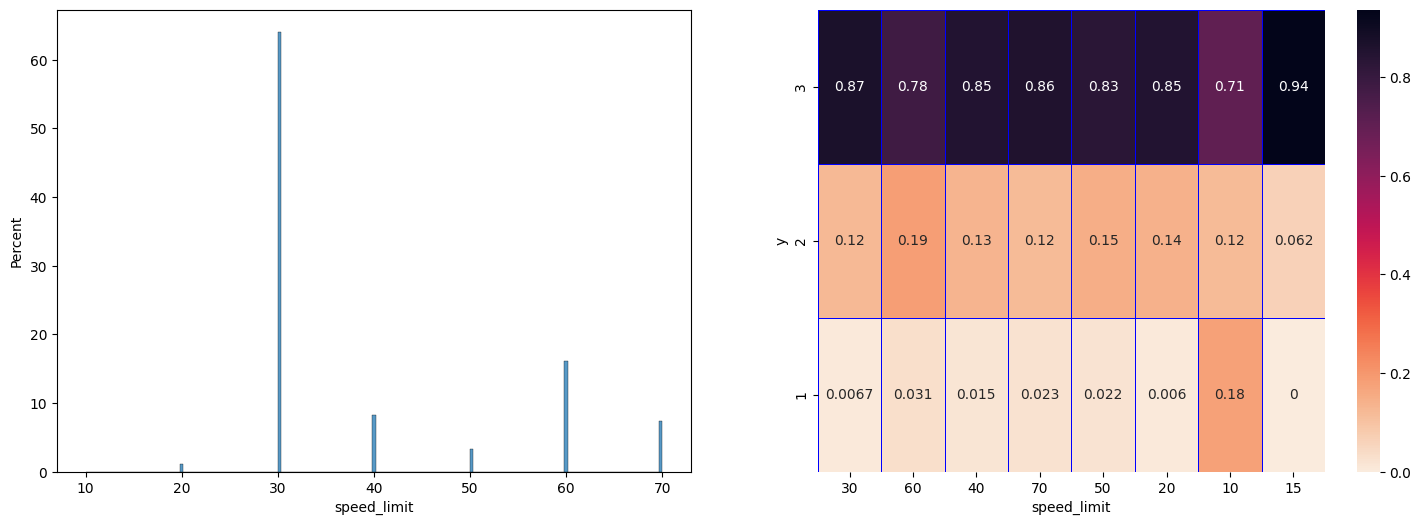

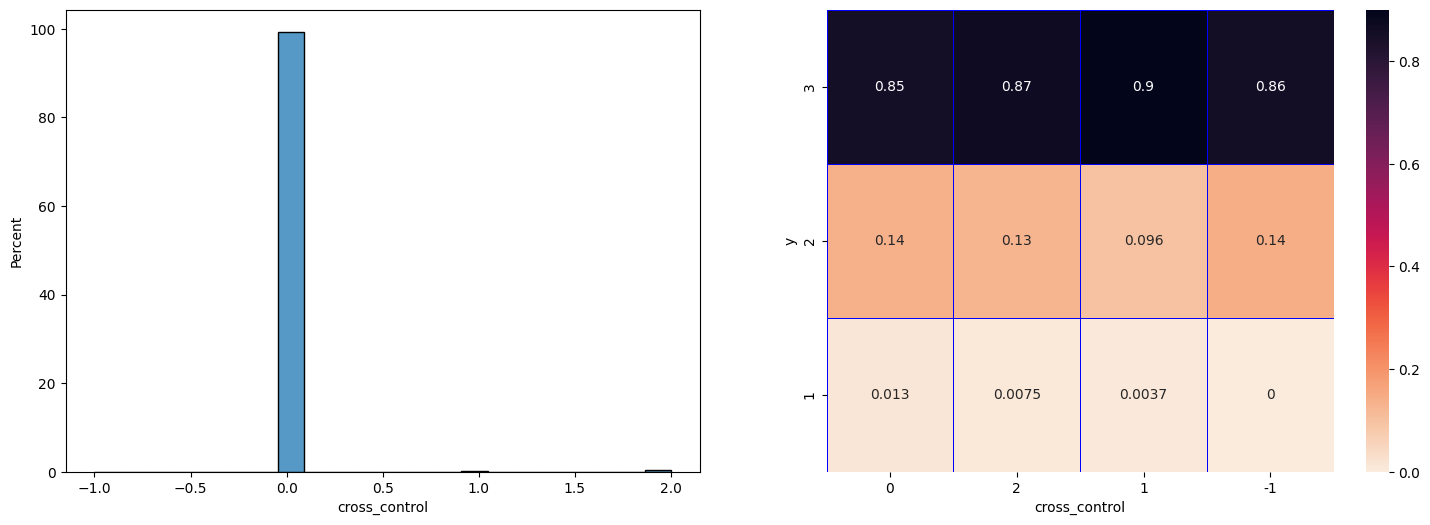

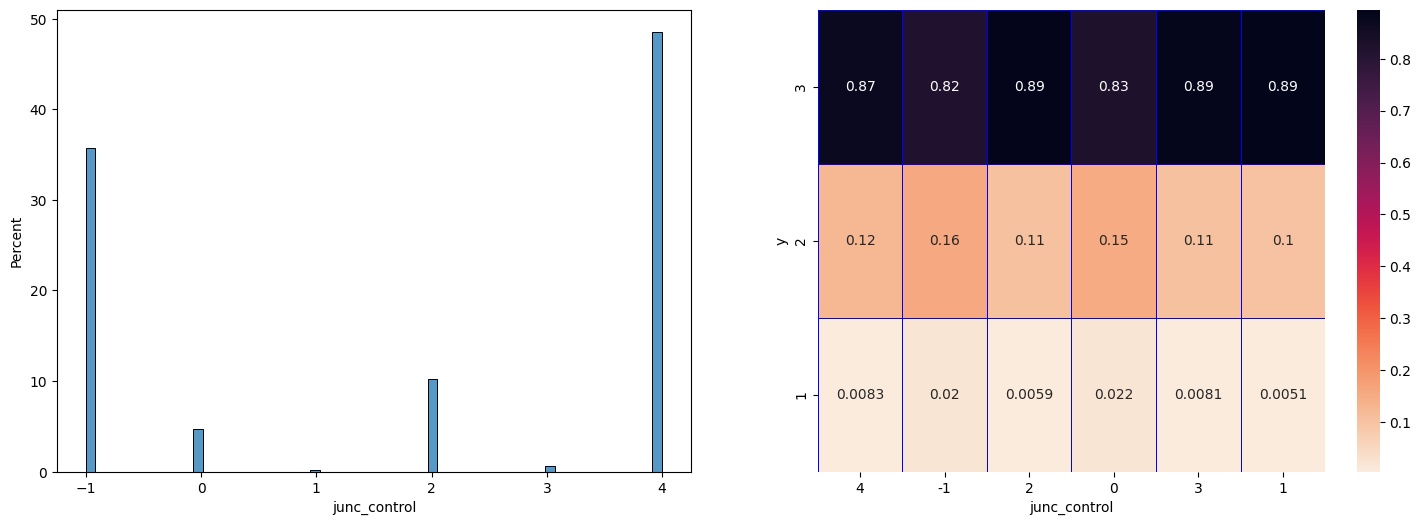

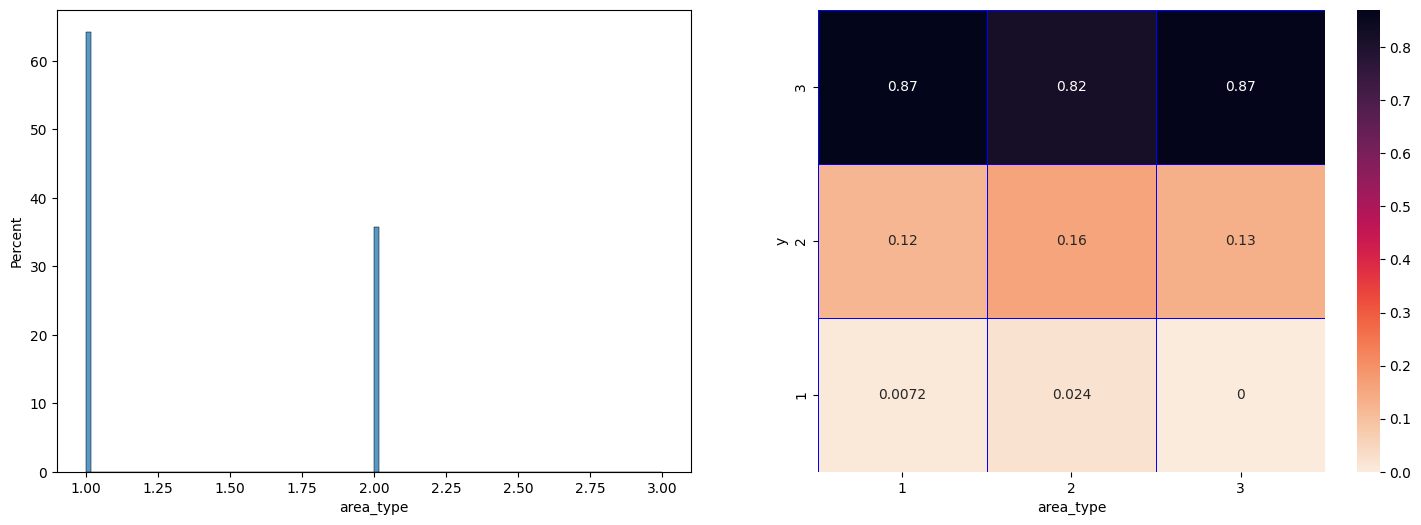

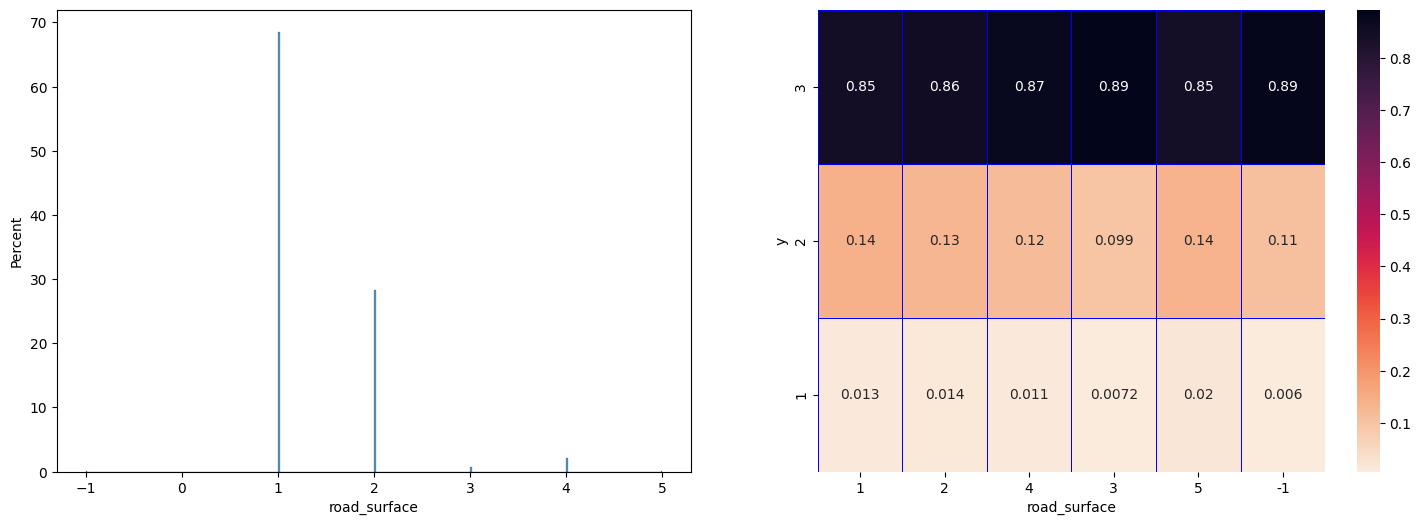

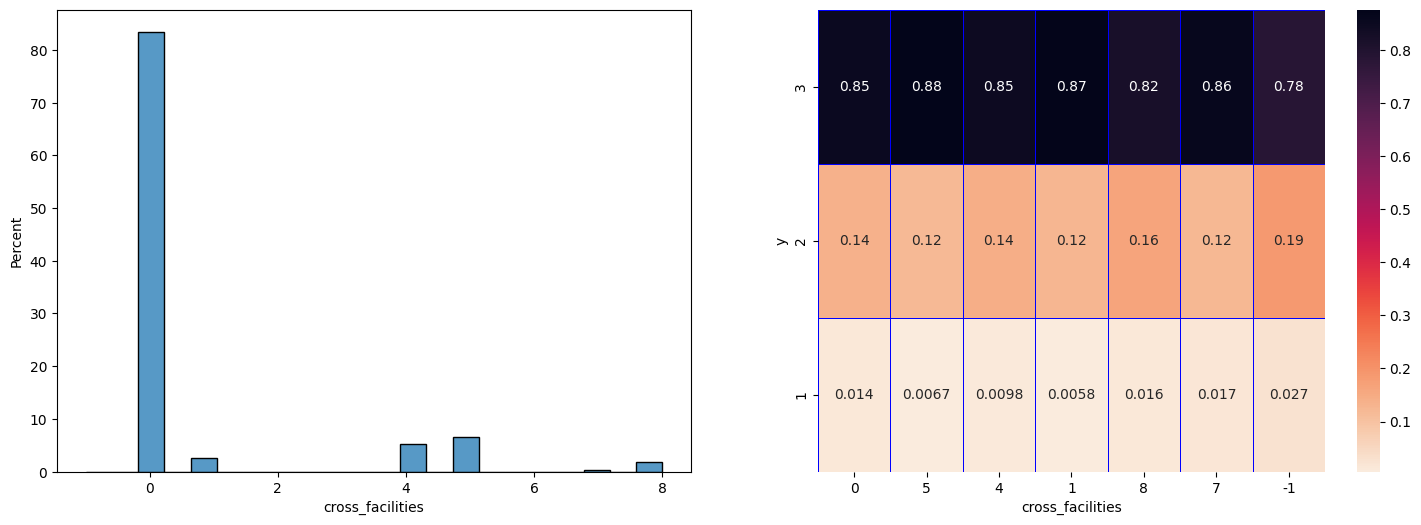

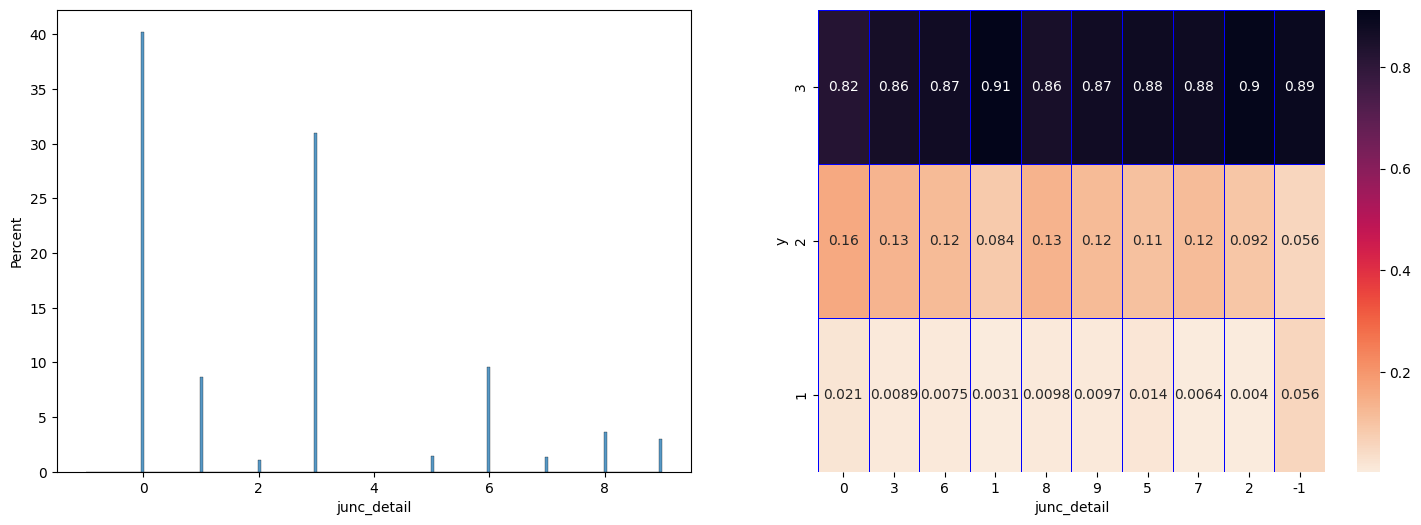

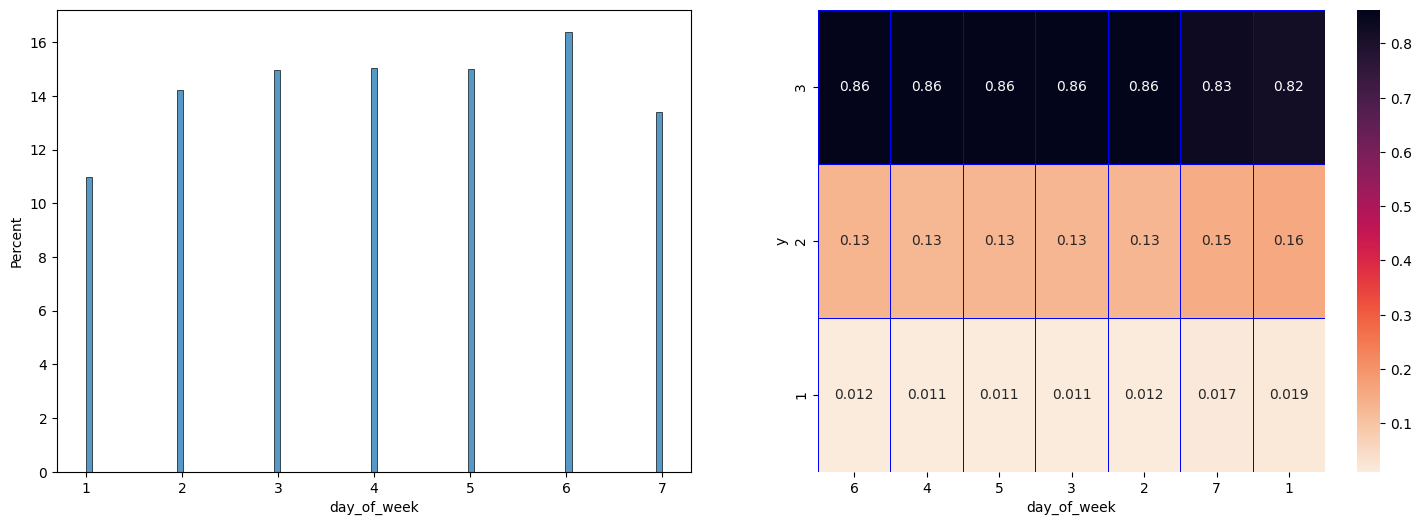

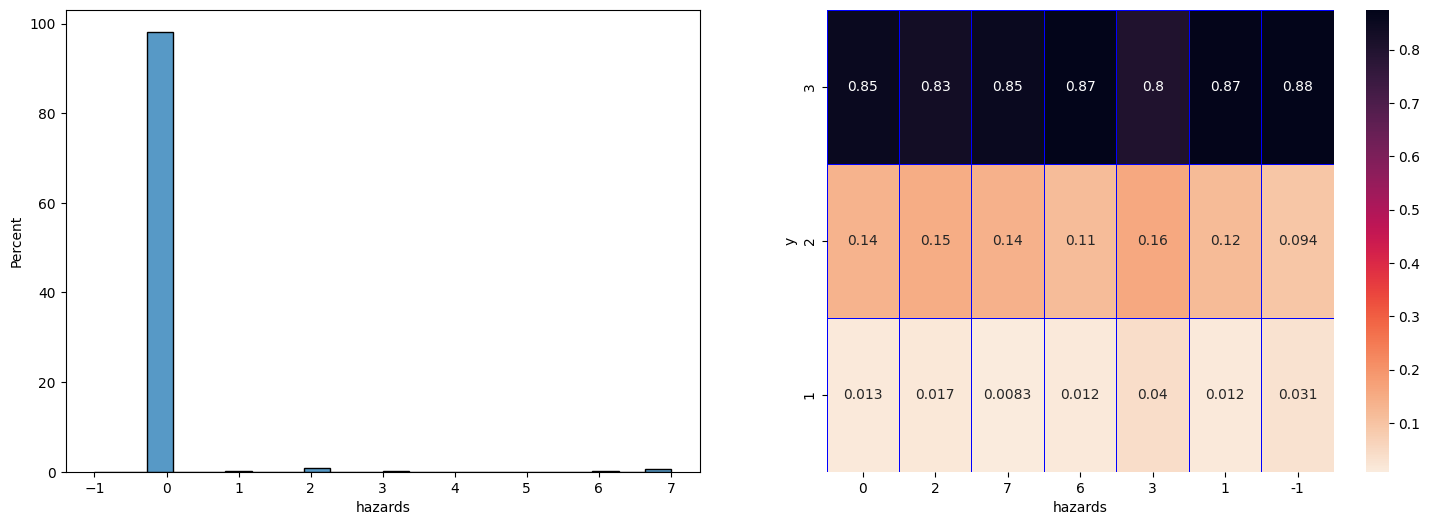

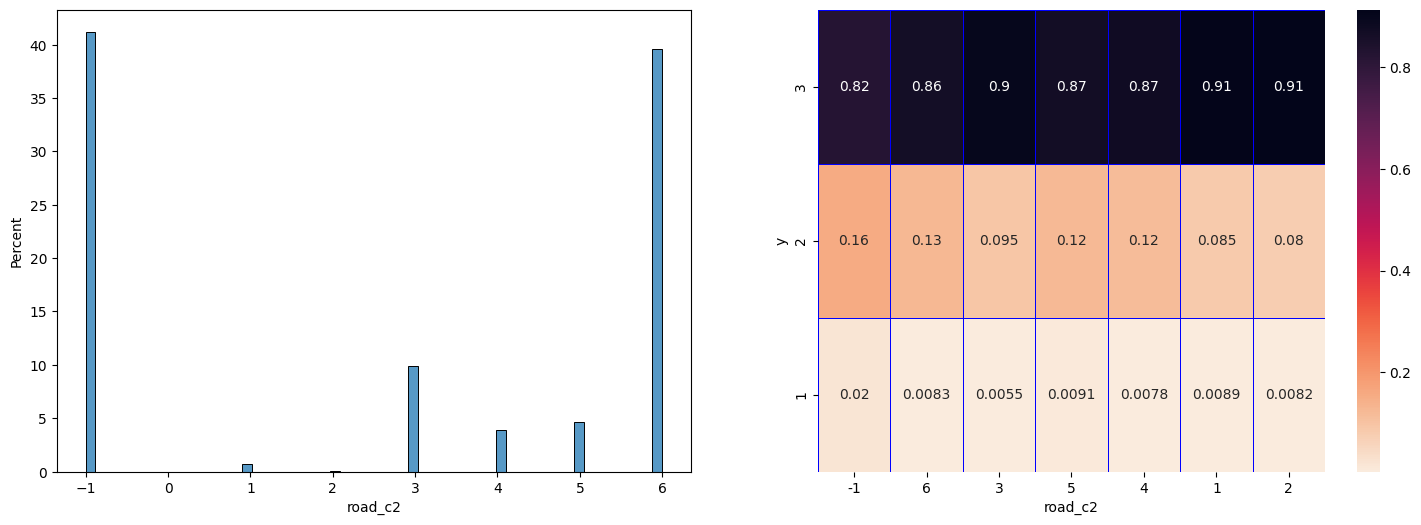

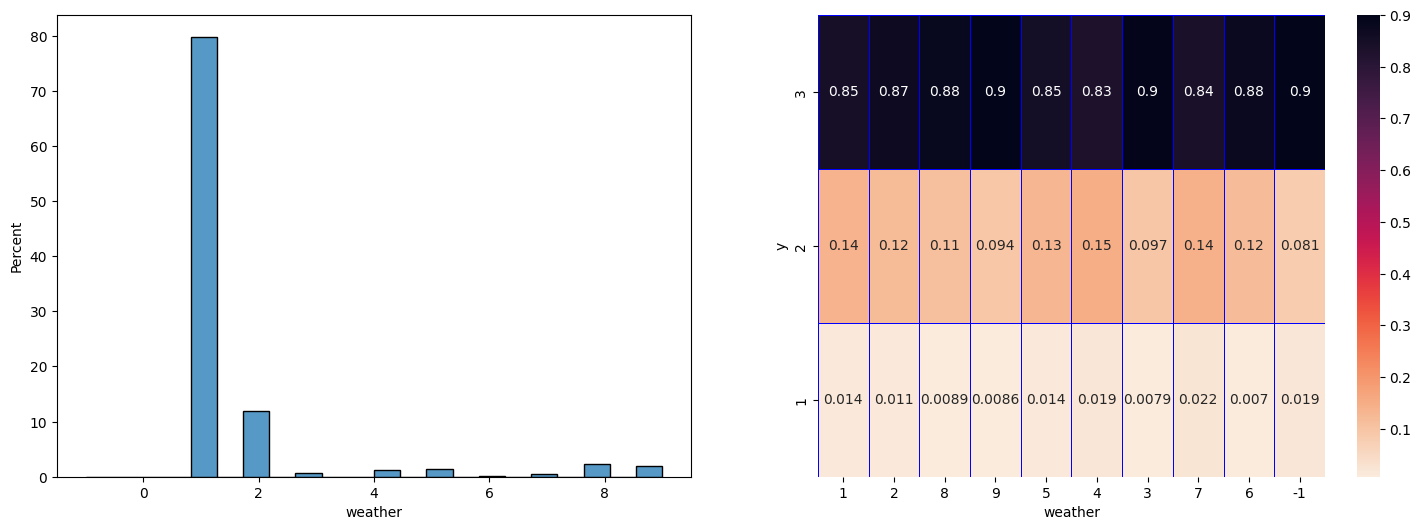

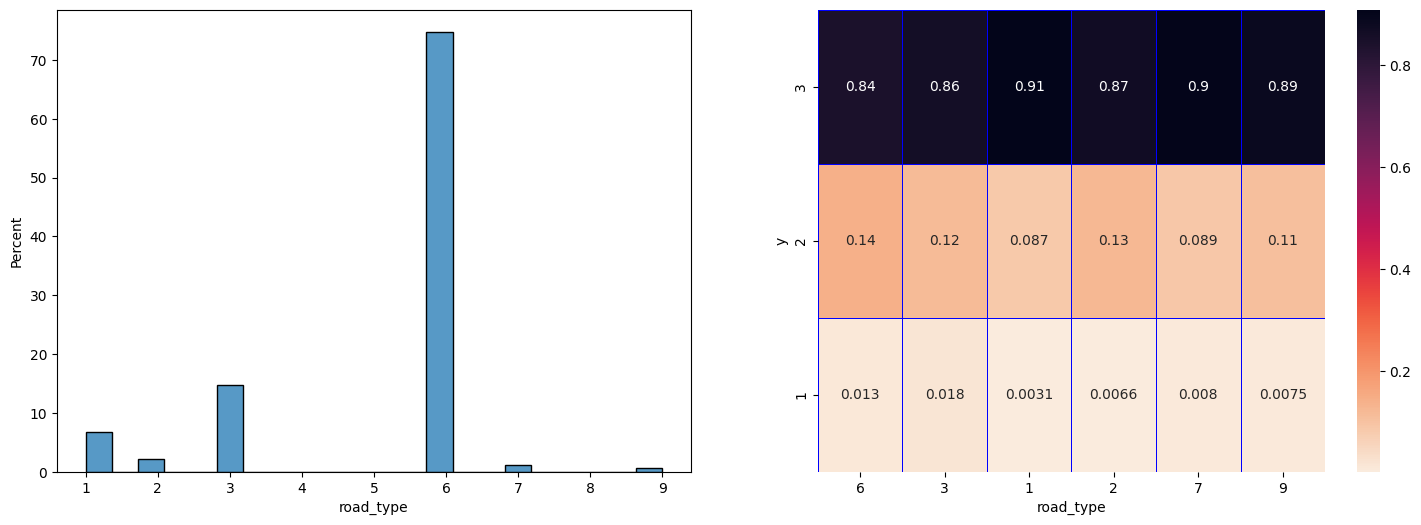

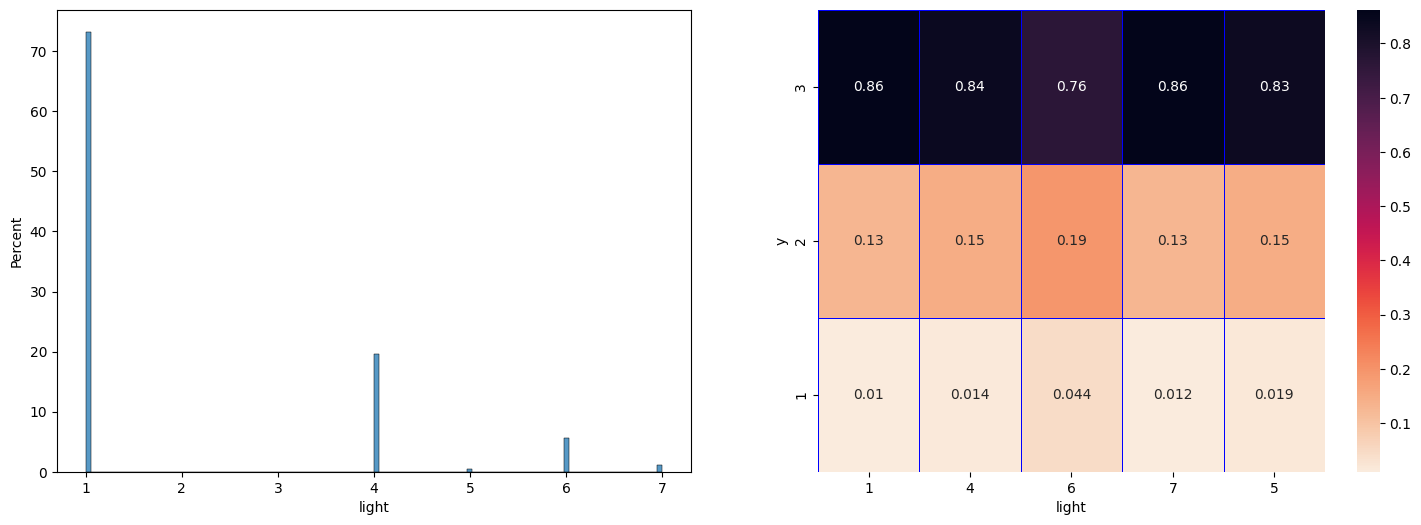

In [84]:
import visual as v
# now it is interesting to understand the conditional probabitili

for c in small_cats:
    figure, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=False, sharey=False)
    # first display distribution
    distribution = sns.histplot(ax=axes[0], data=acc_cat, x=c, stat='percent')
    # second display the condition distribution of the categorical feature over the target variable
    con_dis = v.visualize_cond_prob(acc_cat, target='y', hue=c, show=False)
    axes[1] = con_dis

    # con_dis_2 = v.visualize_cond_prob(acc_cat, target=c, hue='y', show=False)
    # axes[2] = con_dis_2

    plt.show()


In [85]:
# the day of the week does not seem to affect the seriousness of the casuality
ACC.drop(columns=['day_of_week', 'y', 'n_vehs'], inplace=True)

In [86]:
# let's make sure to convert the date to a datetime4
# first convert all dates to the same format

from  datetime import datetime
from dateutil.parser import parse

def uniform_date_format(date_text:str):
    try:
        return datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        pass
    # first parse the date as it is
    dt = parse(date_text)
    return dt.strftime('%d/%m/%Y')

# first make sure to unify the date's format
ACC['date'] = ACC['date'].apply(uniform_date_format)
# convert all the strings to date time objects
ACC['date'] = pd.to_datetime(ACC['date'], format='%d/%m/%Y')

In [87]:
ACC.dtypes

accident_index              object
lng                        float64
lat                        float64
date                datetime64[ns]
time                        object
district                     int64
highway                     object
road_c1                      int64
road_n1                      int64
road_type                    int64
speed_limit                  int64
junc_detail                  int64
junc_control                 int64
road_c2                      int64
road_n2                      int64
cross_control                int64
cross_facilities             int64
light                        int64
weather                      int64
road_surface                 int64
special_conds                int64
hazards                      int64
area_type                    int64
dtype: object

In [88]:
# save the resulting accidents table
processed_data_dir = os.path.join(HOME_PARENT, 'data', 'preprocessed_data')
os.makedirs(processed_data_dir, exist_ok=True)
ACC.to_csv(os.path.join(processed_data_dir, 'accidents_v1.csv'), index=False)

## The Vehicles Data

In [89]:
VE = to_columns(VE, lambda x: x.lower().strip())
print(VE.columns)
COLUMNS_TO_REMOVE = ['vehicle_manoeuvre', 'vehicle_location-restricted_lane', 'junction_location', 'was_vehicle_left_hand_drive?', 
                     'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver','age_band_of_driver', 'propulsion_code',
                     'driver_imd_decile', 'driver_home_area_type']

VE.drop(columns=COLUMNS_TO_REMOVE, inplace=True)
VE.head()

Index(['accident_index', 'vehicle_reference', 'vehicle_type',
       'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       '1st_point_of_impact', 'was_vehicle_left_hand_drive?',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_(cc)', 'propulsion_code',
       'age_of_vehicle', 'driver_imd_decile', 'driver_home_area_type'],
      dtype='object')


,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,1st_point_of_impact,engine_capacity_(cc),age_of_vehicle
0,200501BS00001,1,9,0,0,0,0,0,1,-1,-1
1,200501BS00002,1,11,0,0,0,0,0,4,8268,3
2,200501BS00003,1,11,0,0,4,0,0,4,8300,5
3,200501BS00003,2,9,0,0,0,0,0,3,1762,6
4,200501BS00004,1,9,0,0,0,0,0,1,1769,4


In [90]:
VE.columns
# renaming the columns
NEW_VEH_NAMES = {"accident_index": "acc_index", "vehicle_reference": "veh_ref", "vehicle_type": "veh_type", "towing_and_articulation": "towing",
                 "skidding_and_overturning": "reversed", "hit_object_in_carriageway": "object_in", "vehicle_leaving_carriageway": "veh_left", 
                 "hit_object_off_carriageway": "object_out", '1st_point_of_impact':"impact","engine_capacity_(cc)": "cc", "age_of_vehicle": "veh_age"}

VE = new_col_names(NEW_VEH_NAMES, VE) 

THE vehicle table does not have a unique reference for the car. The primary key is veh_ref + acc_index. To load this data to a database, the veh_ref should be modified to uniquely reprsent the car: a simple merge of veh_ref and accident_index would do the trick.

In [91]:
def fix_veh_ref(row):
    row['veh_ref'] = f"{row['acc_index']}_{row['veh_ref']}"
    return row

VE = VE.apply(fix_veh_ref, axis=1)

In [92]:
VE.to_csv(os.path.join(processed_data_dir, 'vehicles_v1.csv'), index=False)

## The casualities Data

In [93]:
CA.columns = [c.lower() for c in CA.columns]
print(CA.columns)
# drop the last 6 columns
CA.drop(columns=list(CA.columns)[-6:] + ['casualty_reference'], inplace=True)
CA.columns

Index(['accident_index', 'vehicle_reference', 'casualty_reference',
       'casualty_class', 'sex_of_casualty', 'age_of_casualty',
       'age_band_of_casualty', 'casualty_severity', 'pedestrian_location',
       'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_type',
       'casualty_home_area_type'],
      dtype='object')


Index(['accident_index', 'vehicle_reference', 'casualty_class',
       'sex_of_casualty', 'age_of_casualty', 'age_band_of_casualty',
       'casualty_severity', 'pedestrian_location'],
      dtype='object')

In [94]:
# let's fix the naming here
CA_NEW_NAMES = {"accident_index": "acc_index", "vehicle_reference": "veh_ref", 'casualty_class': "cas_type","sex_of_casualty": "cas_sex", 
                'age_of_casualty': "cas_age", 'age_band_of_casualty': "cas_age_band", 'casualty_severity': "cas_y", 'pedestrian_location': "ped_loc"}

CA = new_col_names(CA_NEW_NAMES, CA)
CA.columns

Index(['acc_index', 'veh_ref', 'cas_type', 'cas_sex', 'cas_age',
       'cas_age_band', 'cas_y', 'ped_loc'],
      dtype='object')

In [95]:
# the same modification applied on the vehicle file should be applied to that of casualties
CA = CA.apply(fix_veh_ref, axis=1)
# as it does not seem possible to make a primary key for each casualty out of the provided data
# we can create a simple serieal key by resetting the index
CA.reset_index(inplace=True)
CA.head()

,index,acc_index,veh_ref,cas_type,cas_sex,cas_age,cas_age_band,cas_y,ped_loc
0,0,200501BS00001,200501BS00001_1,3,1,37,7,2,1
1,1,200501BS00002,200501BS00002_1,2,1,37,7,3,0
2,2,200501BS00003,200501BS00003_2,1,1,62,9,3,0
3,3,200501BS00004,200501BS00004_1,3,1,30,6,3,5
4,4,200501BS00005,200501BS00005_1,1,1,49,8,3,0


In [96]:
CA.to_csv(os.path.join(processed_data_dir, 'casualties_v1.csv'), index=False)

# Namesless Section

In [97]:
import pandas as pd
import os
from pathlib import Path

print
processed_data_dir = os.path.join(Path(os.getcwd()).parent, 'data', 'preprocessed_data')
# let's get this shit done by today!!
ACC = pd.read_csv(os.path.join(processed_data_dir, 'accidents_v1.csv'))
CA = pd.read_csv(os.path.join(processed_data_dir, 'casualties_v1.csv'))
VEH = pd.read_csv(os.path.join(processed_data_dir, 'vehicles_v1.csv'))

print(ACC.columns)
print(CA.columns)
print(VEH.columns)


Index(['accident_index', 'lng', 'lat', 'date', 'time', 'district', 'highway',
       'road_c1', 'road_n1', 'road_type', 'speed_limit', 'junc_detail',
       'junc_control', 'road_c2', 'road_n2', 'cross_control',
       'cross_facilities', 'light', 'weather', 'road_surface', 'special_conds',
       'hazards', 'area_type'],
      dtype='object')
Index(['index', 'acc_index', 'veh_ref', 'cas_type', 'cas_sex', 'cas_age',
       'cas_age_band', 'cas_y', 'ped_loc'],
      dtype='object')
Index(['acc_index', 'veh_ref', 'veh_type', 'towing', 'reversed', 'object_in',
       'veh_left', 'object_out', 'impact', 'cc', 'veh_age'],
      dtype='object')


In [98]:
# let's check the types 
print(ACC.dtypes, end='\n' * 2)
print(CA.dtypes, end='\n' * 2)
print(VEH.dtypes, end='\n' * 2)

accident_index       object
lng                 float64
lat                 float64
date                 object
time                 object
district              int64
highway              object
road_c1               int64
road_n1               int64
road_type             int64
speed_limit           int64
junc_detail           int64
junc_control          int64
road_c2               int64
road_n2               int64
cross_control         int64
cross_facilities      int64
light                 int64
weather               int64
road_surface          int64
special_conds         int64
hazards               int64
area_type             int64
dtype: object

index            int64
acc_index       object
veh_ref         object
cas_type         int64
cas_sex          int64
cas_age          int64
cas_age_band     int64
cas_y            int64
ped_loc          int64
dtype: object

acc_index     object
veh_ref       object
veh_type       int64
towing         int64
reversed       int64
object_in     

In [99]:
all(VEH['veh_ref'].value_counts() == 1)

True

In [100]:
print(CA['veh_ref'].head())
print(VEH['veh_ref'].head())

0    200501BS00001_1
1    200501BS00002_1
2    200501BS00003_2
3    200501BS00004_1
4    200501BS00005_1
Name: veh_ref, dtype: object
0    200501BS00001_1
1    200501BS00002_1
2    200501BS00003_1
3    200501BS00003_2
4    200501BS00004_1
Name: veh_ref, dtype: object


In [101]:
set(CA['veh_ref']).issubset(set(VEH['veh_ref']))

True